# Dealing with unclean data

In this notebook we use `pyspark` library to read `bridge.csv` to filter out padding characters, blank lines, lines with missing values or containing missing values and lines containing non-numerical characters. In order to clean the CSV file we'll store the file content into a resilient distributed dataset (RDD). The header file is the *weight* and *deformation*, which are float values, of a bridge design. Finally we plot a scatter plot by using the `matplotlib` library.

First, we import the Python modules we are going to use. `pyspark` provides scalable data processing but in our case it's usefull since allow us to store the file content into RDDs of key-value pairs. `matplotlib` is for plotting a scatter plot of the the clean data. `numpy` library will convert the resulting RDD into a NumPy array of floats to use it then to plot. 

In [1]:
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import numpy as np

**Step 1. Initialize a SparkConf object**

In [2]:
spark_conf = SparkConf().setAppName('CSVCleaner').setMaster('local[4]')

**Step 2. Create a SparkContext object**

In [3]:
spark_context = SparkContext.getOrCreate(spark_conf)

**Step 3. Read bridge.csv into a RDD and discard header (store header as a literal string by inspecting the CSV file)**

In [4]:
header = 'Weight,Deformation'
lines = spark_context.textFile("data/bridge.csv").filter(lambda line: header not in line).cache()

**Step 4. Filter rows with less than two columns (that is, invalid lines)**

In [5]:
valid_lines = lines.filter(lambda line: len(line.split(",")) >= 2).cache()

**Step 5. Convert each row to a tuple (weight, deformation) by cleaning padding characters and by removing the third component (produced by a comma at the end of line)**

In [6]:
rdd_pairs = valid_lines.map(lambda line: tuple(line.strip().split(',')[:2])).cache()

**Step 6. Filter out rows with missing values**

In [7]:
clean_rdd_pairs = rdd_pairs.filter(lambda line: all(x.strip() for x in line)).cache()

**Step 7.1. Function to check if a string is a float representation**

In [8]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

**Step 7.2. Filter in only pairs containing float-type values**

In [9]:
numerical_rdd = clean_rdd_pairs.filter(lambda tup: is_float(tup[0]) and is_float(tup[1]))

**Step 8. Print the resulting clean data**

In [10]:
for index, pair in enumerate(numerical_rdd.collect()):
    print(f'Line {index+1}: {pair}')

Line 1: ('0.1600004095193499', '0.599999565925713')
Line 2: ('0.7999996334783612', '0.105573019041743')
Line 3: ('0.3474026835213373', '0.41059125458931517')
Line 4: ('0.3409188533102768', '0.4161174319177898')
Line 5: ('0.33448446398543363', '0.4216536843155324')
Line 6: ('0.35390522300019', '0.4051006617019322')
Line 7: ('0.3280925245214544', '0.42720638686411727')
Line 8: ('0.3217358217215534', '0.43278238841939665')
Line 9: ('0.36039794488768706', '0.3996684723945372')
Line 10: ('0.3154172733712044', '0.4383797783455403')
Line 11: ('0.3669234753668437', '0.3942579191642874')
Line 12: ('0.37345638999357544', '0.3888892255982278')
Line 13: ('0.3091488764126171', '0.44398842406579203')
Line 14: ('0.3800121516706126', '0.38354874656944227')
Line 15: ('0.30295098086750766', '0.44959017652156535')
Line 16: ('0.38657333470529276', '0.3782497818184258')
Line 17: ('0.29063517731969263', '0.4608941011769619')
Line 18: ('0.28454896813201636', '0.46656868557912423')
Line 19: ('0.39313313091886

**Step 9. Convert array of strings as NumPy arrays of float values**

In [11]:
y_coords = np.array(numerical_rdd.map(lambda point: point[0]).collect(), dtype=float)
x_coords = np.array(numerical_rdd.map(lambda point: point[1]).collect(), dtype=float)

**Step 9. Plot a weight versus deformation scatter plot**

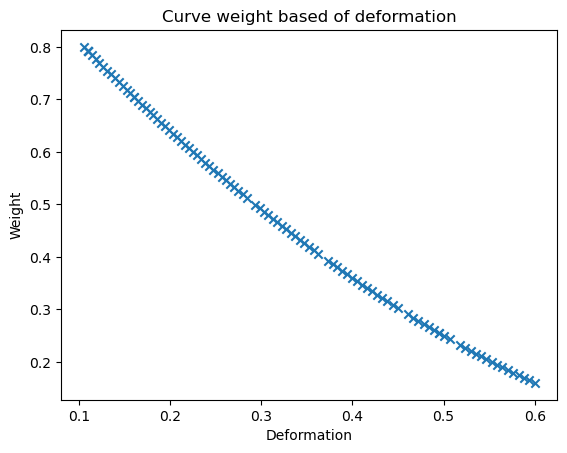

In [12]:
plt.scatter(x_coords, y_coords, marker='x')
plt.title("Curve weight based of deformation")
plt.xlabel("Deformation")
plt.ylabel("Weight")
plt.show()

*(The end.)*